In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from IPython.display import display, HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pickle
import seaborn as sns
import itertools
from time import time
from tqdm import tqdm_notebook

sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

In [3]:
from simulations.scenarios import *
from simulations.agent import *
from simulations.utils import Context
from scripts.parse_enron import Message

In [4]:
sns.set_context("paper", font_scale=1.5)
sns.set_style("white")
sns.set_palette(sns.cubehelix_palette(n_colors=4))

In [5]:
parsed_logs_folder = '../Enron/parsing/'
social_graph = pickle.load(open(parsed_logs_folder + "social.pkl", "rb"))

enron_log = pickle.load(open(parsed_logs_folder + "replay_log.pkl", "rb"))
LOG_SIZE = len(enron_log)

In [6]:
dynamic_private_setting = AgentSettings(
    key_update_every_nb_sent_emails=None, key_update_every_nb_days=90)
dynamic_public_setting = AgentSettings(
    key_update_every_nb_sent_emails=None, key_update_every_nb_days=90,
    introduction_policy=public_contacts_policy)

## Sample plots

### Plotting code

In [7]:
def make_encryption_status_plots(scenario_name, reports, breakpoints=None,
                                 mask_fn=None):
    if breakpoints is None:
        breakpoints = range(len(reports) + 1)
        
    fig, axes = plt.subplots(nrows=5, ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(30)
    axes = list(itertools.chain.from_iterable(axes))

    for i, (offset, report, ax) in enumerate(
            zip(breakpoints[:-1], reports, axes)):
        if mask_fn is not None:
            mask = mask_fn(report)
        else:
            mask = None
        visualize_encryption_status_history(
            '%s (log chunk @%d)' % (scenario_name, offset),
            report.encryption_status_data,
            report.link_status_data,
            mask=mask,
            ax=ax)
        
def compute_enc_stats_in_batches(enc_status_data, link_status_data,
                                 mask=None, batch_size=1000):
    log_size = enc_status_data.index[-1] + 1
    batch_stats_data = pd.DataFrame(
        columns=['Stale key',
                 'Encrypted',
                 'Plaintext (initial contact)',
                 'Plaintext (follow-up)'])
    for i in range(0, log_size, batch_size):
        enc_status_batch = enc_status_data.loc[i:i+batch_size].dropna()
        link_status_batch = link_status_data.loc[i:i+batch_size].dropna()
        if mask is not None:
            mask_batch = mask.loc[i:i+batch_size]
            enc_status_batch = enc_status_batch[mask_batch]
            link_status_batch = link_status_batch[mask_batch]

        if len(enc_status_batch) == 0:
            continue

        encrypted_prop = np.mean(enc_status_batch == EncStatus.encrypted) * 100
        stale_prop = np.mean(enc_status_batch == EncStatus.stale) * 100
        
        # Proportion of initial contacts
        plain_status_batch = link_status_batch[enc_status_batch == EncStatus.plaintext]
        greeting_mask = plain_status_batch['greeting'] > 0
        followup_mask = plain_status_batch['followup'] > 0
        greeting_prop = np.sum(greeting_mask & ~followup_mask) \
                        / len(link_status_batch) * 100
        followup_prop = np.sum(followup_mask) / len(link_status_batch) * 100
        
        batch_stats_data.loc[i] = [stale_prop, encrypted_prop, greeting_prop,
                                   followup_prop]

    return batch_stats_data

def visualize_encryption_status_history(
        title, enc_status_data, link_status_data, mask=None,
        batch_size=1000, legend_kwargs=None, ax=None,
        show_title=False, show_legend=False):
    if legend_kwargs is None:
        legend_kwargs = {}
    if ax is None:
        fig, ax = plt.subplots()
    
    batch_stats_data = compute_enc_stats_in_batches(
        enc_status_data, link_status_data, mask, batch_size)
    batch_stats_data.plot.area(ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1], frameon=True,
                       **legend_kwargs)
    if not show_legend:
        legend.remove()
    if show_title:
        ax.set_title(title)
    ax.set_xlabel("Email sent")
    ax.set_ylabel("Email encryption status, %")
    ax.set_ylim(0, 100)
    
def get_average_diversity_data(report, log_size, batch_size=2500, mask=None):
    
    def collect_data_points(series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            for series in series_dict.values():
                data_slice = series.loc[offset:offset + batch_size]
                if mask is not None:
                    mask_batch = mask.loc[offset:offset+batch_size]
                    data_slice = data_slice[mask_batch]
                data_slice = data_slice.dropna().values
                if len(data_slice) == 0:
                    continue
                flattened_values = []
                for item_list in data_slice:                    
                    flattened_values.extend(item_list)
                if flattened_values:
                    data_point = np.array(flattened_values).mean()
                    data_points_by_batch[offset + batch_size].append(
                        data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    diversity_data = collect_data_points(
        report.social_evidence_diversity_data)
    
    return diversity_data

def get_average_storage_data(report, log_size, batch_size=2500):
    
    def collect_data_points(series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            for series in series_dict.values():
                data_slice = series.loc[offset:offset + batch_size] \
                            .dropna().values
                if len(data_slice) == 0:
                    continue
                data_point = data_slice.mean() / 1024
                data_points_by_batch[offset + batch_size].append(data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    bandwidth_data = collect_data_points(report.outgoing_bandwidth_data)
    gossip_storage_data = collect_data_points(report.gossip_store_size_data)
    local_storage_data = collect_data_points(report.local_store_size_data)
    
    return bandwidth_data, gossip_storage_data, local_storage_data

def get_average_enc_status_data(report, mask=None, batch_size=1000):
    cuts = [4000, 7000, 10000]

    enc_stats_batches = compute_enc_stats_in_batches(
        report.encryption_status_data, report.link_status_data, mask=mask)
    
    if mask is not None:
        enc_status_data = report.encryption_status_data[mask]
    else:
        enc_status_data = report.encryption_status_data
        
    enc_avg_data = pd.DataFrame(columns=['Last batch average', 'Overall average'])
    for cut in cuts:
        # Average of immediate %
        batch_avg = enc_stats_batches['Encrypted'].loc[cut-batch_size]

        # Overall average
        slice_stats = enc_status_data.loc[:cut].value_counts()
        nb_encrypted = slice_stats.get(EncStatus.encrypted) or 0 
        overall_avg = nb_encrypted / slice_stats.sum() * 100

        enc_avg_data.loc[cut] = (batch_avg, overall_avg)

    return enc_avg_data

In [8]:
with dynamic_public_setting.as_default():
    context = Context(enron_log[0:1000], social_graph=social_graph)
    public_report = simulate_claimchain(context, pbar=tqdm_notebook)

INFO:simulations.scenarios:Simulating ClaimChain
INFO:simulations.scenarios:Common agent settings: AgentSettings(conflict_resolution_policy=<function latest_timestamp_resolution_policy at 0x7f09d9a5dd90>, chain_update_policy=<function immediate_chain_update_policy at 0x7f09d9a63950>, introduction_policy=<function public_contacts_policy at 0x7f09d9a63a60>, key_update_every_nb_sent_emails=None, key_update_every_nb_days=90)


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

INFO:root:Emails: Sent: 854, Encrypted: 121


In [9]:
with dynamic_private_setting.as_default():
    context = Context(enron_log[0:1000], social_graph=social_graph)
    private_report = simulate_claimchain(context, pbar=tqdm_notebook)

INFO:simulations.scenarios:Simulating ClaimChain
INFO:simulations.scenarios:Common agent settings: AgentSettings(conflict_resolution_policy=<function latest_timestamp_resolution_policy at 0x7f09d9a5dd90>, chain_update_policy=<function immediate_chain_update_policy at 0x7f09d9a63950>, introduction_policy=<function implicit_cc_introduction_policy at 0x7f09d9a639d8>, key_update_every_nb_sent_emails=None, key_update_every_nb_days=90)


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

INFO:root:Emails: Sent: 854, Encrypted: 100


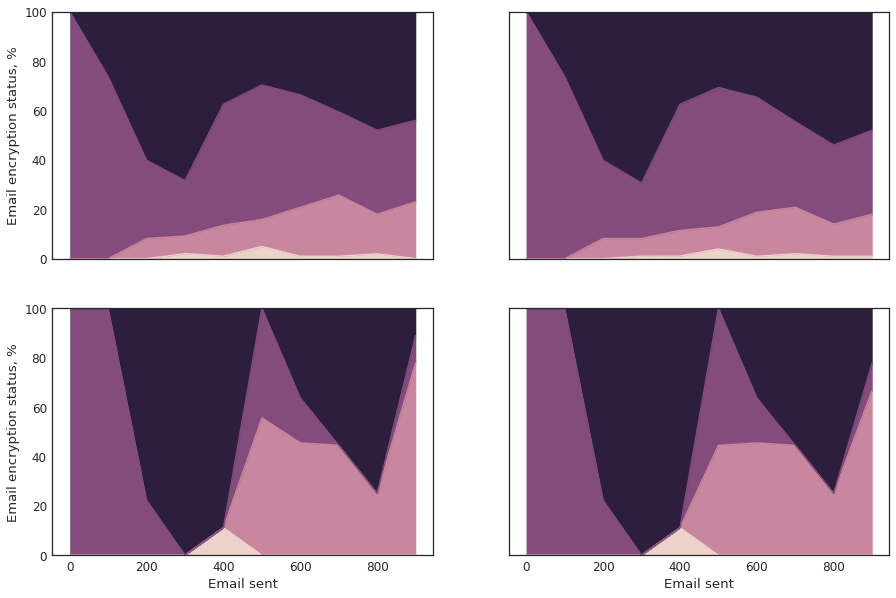

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
batch_size = 100

visualize_encryption_status_history(
    'Public ClaimChain',
    public_report.encryption_status_data,
    public_report.link_status_data,
    batch_size=batch_size,
    ax=axes[0][0])

visualize_encryption_status_history(
    'Private ClaimChain',
    private_report.encryption_status_data,
    private_report.link_status_data,
    batch_size=batch_size,
    ax=axes[0][1])

visualize_encryption_status_history(
    'Public ClaimChain (Userset only)',
    public_report.encryption_status_data,
    public_report.link_status_data,
    public_report.participants_type_data == ParticipantsTypes.userset,
    batch_size=batch_size,
    ax=axes[1][0])

visualize_encryption_status_history(
    'Private ClaimChain (Userset only)',
    private_report.encryption_status_data,
    private_report.link_status_data,
    private_report.participants_type_data == ParticipantsTypes.userset,
    batch_size=batch_size,
    ax=axes[1][1])

fig.set_figwidth(15)
fig.set_figheight(10)

In [11]:
LOG_CHUNK_SIZE = 10000
TOTAL_NUM_CHUNKS = 11
MAX_NUM_CHUNKS_TO_SIM = 11

In [12]:
breakpoints = [int(i) for i in np.linspace(0, LOG_SIZE, 11)]
breakpoints = breakpoints[:MAX_NUM_CHUNKS_TO_SIM + 1]
breakpoints

[0, 24594, 49188, 73782, 98377, 122971, 147565, 172160, 196754, 221348, 245943]

## Plot private ClaimChain at different starting points in the log

In [13]:
private_reports = []

# Load reports
for i in breakpoints[:-1]:
    with open('reports/private_claimchain_report-%d.pkl' % i, 'rb') as h:
        report = pickle.load(h)
        private_reports.append(report)

Global encryption traffic

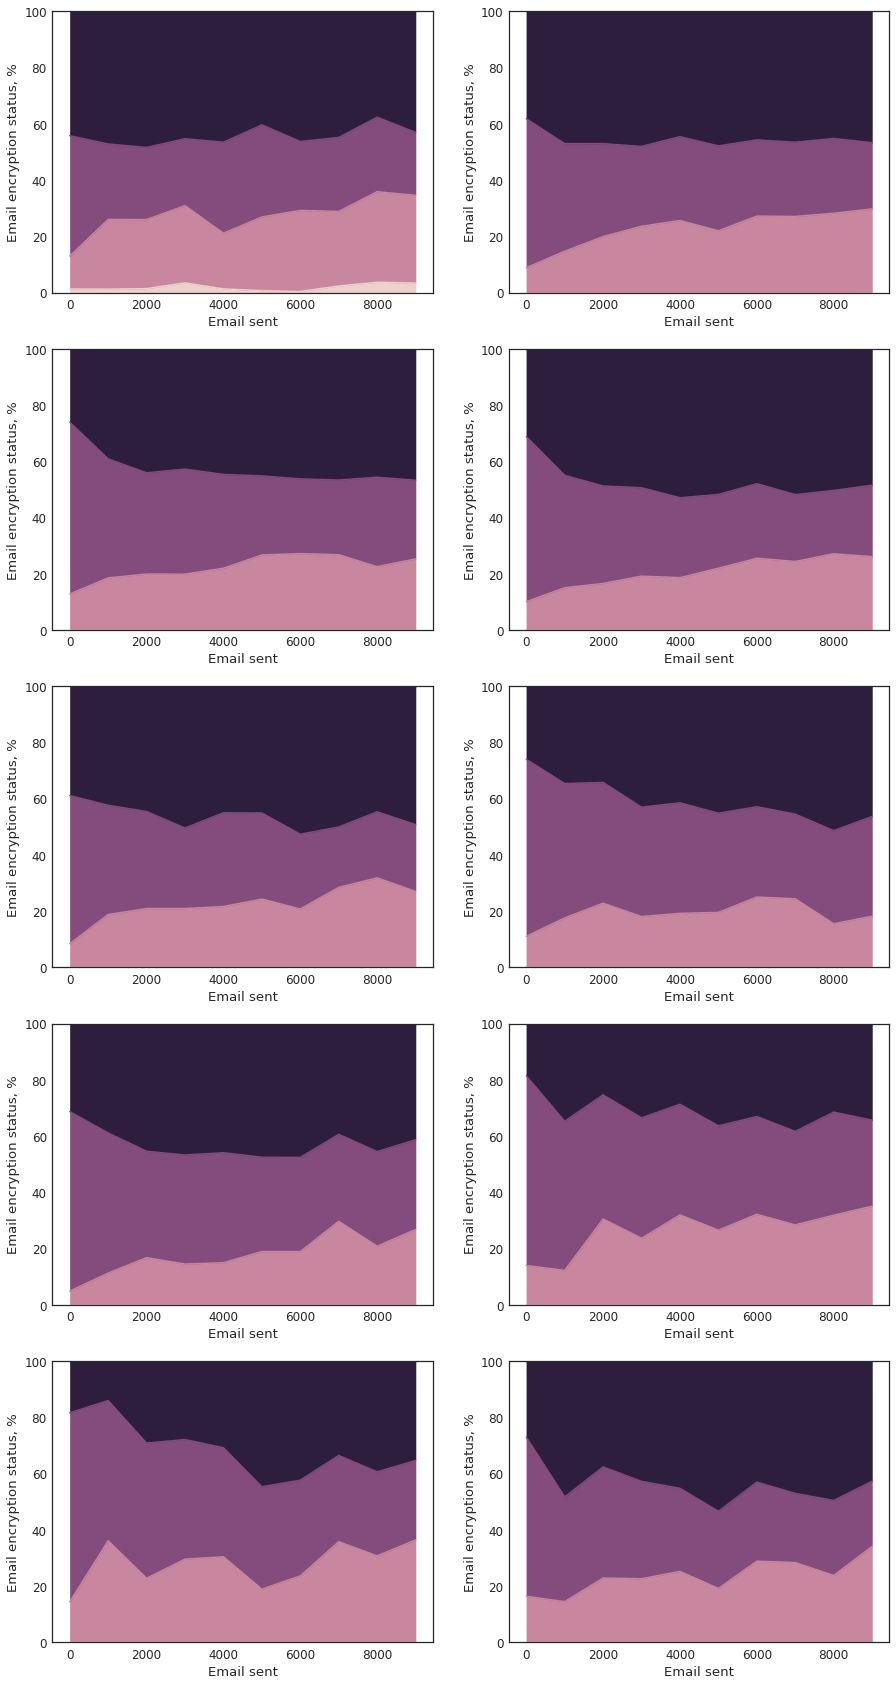

In [14]:
make_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints)

Traffic within the userset

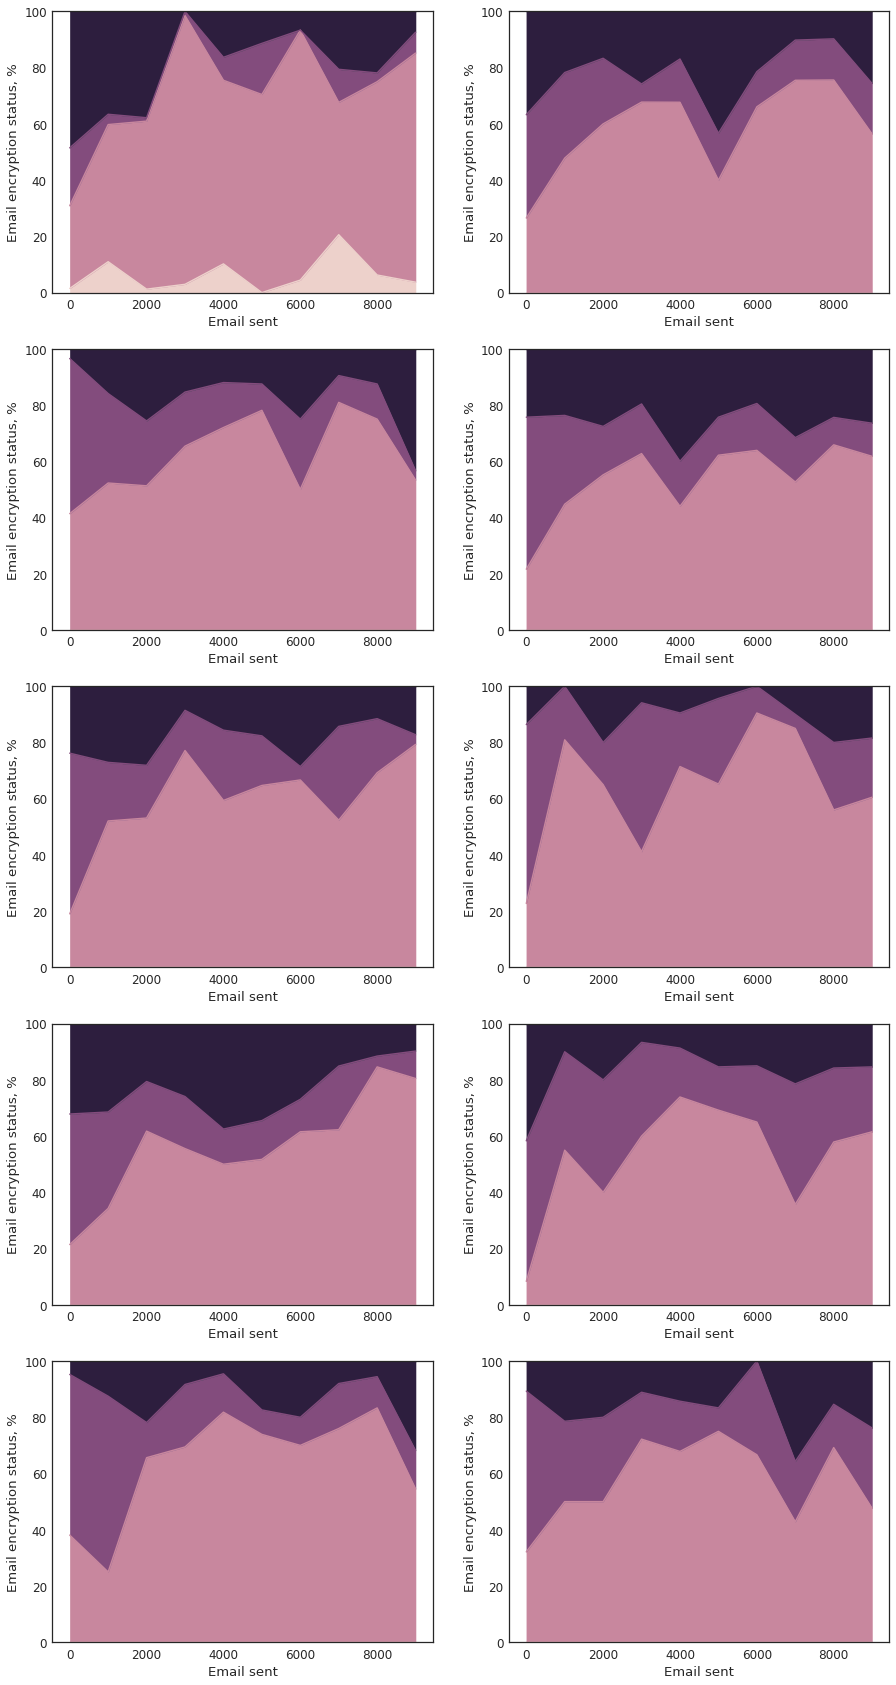

In [15]:
make_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints,
                             mask_fn=lambda report: report.participants_type_data == ParticipantsTypes.userset)

Average encryption proportions

In [16]:
summaries = []

for i, (offset, report) in enumerate(zip(breakpoints, private_reports)):
    display(HTML('<h4>@%d</h4>' % offset))
    a = get_average_enc_status_data(report)
    b = get_average_enc_status_data(report,
        mask=report.participants_type_data==ParticipantsTypes.userset)
    df = pd.concat({'global': a, 'userset': b}, axis=1)
    summaries.append(df)
    display(df)

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           27.466938       22.491441          95.588235       58.000000
7000           28.846154       23.579882          88.888889       63.242009
10000          31.211499       25.523574          81.481481       63.465160

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           23.594378       16.776316          67.741935       47.435897
7000           27.208122       20.286500          66.071429       54.397394
10000          29.757085       22.711143          56.410256       59.080460

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           19.875776       17.779483          65.384615       52.173913
7000           27.179487       20.998682          50.000000       58.139535
10000          25.284974       22.126260          53.333333       61.073826

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           19.168357       15.192455          62.745098       47.096774
7000           25.510204       18.120903          63.888889       51.383399
10000          26.109391       20.429887          61.764706       54.025974

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           20.944559       17.287785          77.142857       49.044586
7000           20.780591       19.392315          66.666667       53.303965
10000          27.024185       22.278057          79.310345       57.095710

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           18.093174       17.439057          41.176471       52.500000
7000           25.026511       19.103522          90.476190       62.758621
10000          18.232044       19.211346          60.526316       63.596491

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           14.498934       11.843516          55.555556       43.548387
7000           18.918919       14.307692          61.538462       47.783251
10000          26.797386       17.794701          80.487805       57.275542

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           23.664921       20.200422          60.000000       43.055556
7000           32.191070       24.539326          65.000000       56.028369
10000          35.074627       26.700966          61.538462       55.080214

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           29.557158       25.792208          69.444444       55.238095
7000           23.584906       25.149076          70.000000       62.941176
10000          36.382323       27.904554          54.545455       65.106383

global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           22.577320       19.084562          72.222222       48.571429
7000           28.840125       21.359799          66.666667       56.637168
10000          34.090909       23.569723          47.619048       55.279503

In [17]:
# Stats over all chunks
global_last_batch_df = pd.concat(
    [s['global']['Last batch average'] for s in summaries], axis=1)
userset_last_batch_df = pd.concat(
    [s['userset']['Last batch average'] for s in summaries], axis=1)
global_overall_df = pd.concat(
    [s['global']['Overall average'] for s in summaries], axis=1)
userset_overall_df = pd.concat(
    [s['userset']['Overall average'] for s in summaries], axis=1)

def compute_stats_over_chunks(data):
    return pd.DataFrame({
        'Avg': data.mean(axis=1), 
        'Std': data.std(axis=1),
        'Std * 2.26': data.std(axis=1) * 2.26   # 95% t-val for df=9
    })

display(pd.concat({
    'Last batch average (global)': compute_stats_over_chunks(global_last_batch_df),
    'Last batch average (userset)': compute_stats_over_chunks(userset_last_batch_df),
}, axis=1))

display(pd.concat({
    'Overall average (global)': compute_stats_over_chunks(global_overall_df),
    'Overall average (userset)': compute_stats_over_chunks(userset_overall_df),
}, axis=1))

Last batch average (global)                       \
                              Avg       Std Std * 2.26   
4000                    21.944151  4.444571  10.044731   
7000                    25.808609  3.963513   8.957539   
10000                   28.996442  5.473595  12.370325   

      Last batch average (userset)                        
                               Avg        Std Std * 2.26  
4000                     66.700143  14.222856  32.143654  
7000                     68.919719  12.183749  27.535273  
10000                    63.701721  12.307157  27.814175

Overall average (global)                      Overall average (userset)  \
                           Avg       Std Std * 2.26                       Avg   
4000                 18.388724  3.852145   8.705847                 49.666464   
7000                 20.683770  3.253945   7.353916                 56.661489   
10000                22.825021  3.224235   7.286770                 59.107926   

                            
            Std Std * 2.26  
4000   4.820174  10.893592  
7000   5.223656  11.805462  
10000  3.987367   9.011450

## Plot public ClaimChain simulation data at one of the points

Pick one chunk

In [18]:
offset = breakpoints[4]
private_report = private_reports[4]

In [19]:
# Load computed reports
with open('reports/public_claimchain_report-%d.pkl' % offset, 'rb') as h:
    public_report = pickle.load(h)

Compare public and private versions

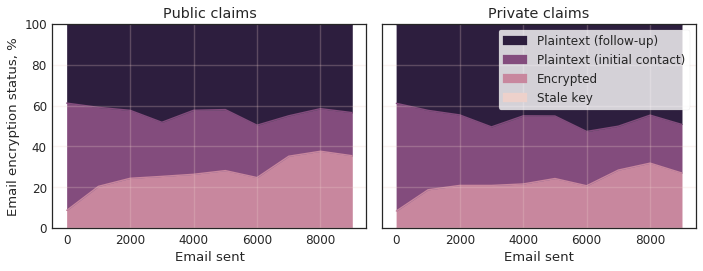

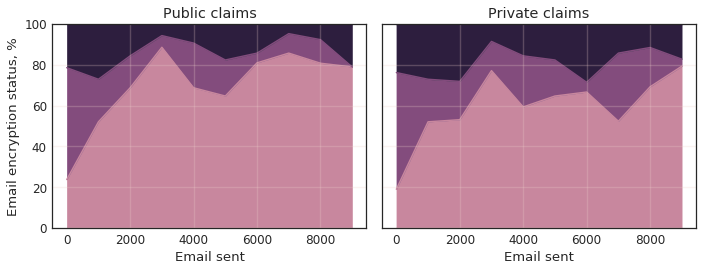

In [20]:
batch_size = 1000

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_tight_layout(tight=True)

visualize_encryption_status_history(
    'Public claims',
    public_report.encryption_status_data,
    public_report.link_status_data,
    batch_size=batch_size,
    show_title=True,
    ax=axes[0])

visualize_encryption_status_history(
    'Private claims',
    private_report.encryption_status_data,
    private_report.link_status_data,
    batch_size=batch_size,
    show_legend=True,
    show_title=True,
    ax=axes[1])
fig.set_figwidth(10)

for tick in [20, 40, 60, 80]:
    axes[0].axhline(tick, 0, 10000, alpha=.25, linestyle='-')
    axes[1].axhline(tick, 0, 10000, alpha=.25, linestyle='-')
    
for tick in [2000, 4000, 6000, 8000]:
    axes[0].axvline(tick, 0, 100, alpha=.25, linestyle='-')
    axes[1].axvline(tick, 0, 100, alpha=.25, linestyle='-')

fig.savefig('images/enc_status_data_global.pdf')

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_tight_layout(tight=True)

visualize_encryption_status_history(
    'Public claims',
    public_report.encryption_status_data,
    public_report.link_status_data,
    public_report.participants_type_data == ParticipantsTypes.userset,
    batch_size=batch_size,
    show_title=True,
    ax=axes[0])

visualize_encryption_status_history(
    'Private claims',
    private_report.encryption_status_data,
    private_report.link_status_data,
    private_report.participants_type_data == ParticipantsTypes.userset,
    batch_size=batch_size,
    show_title=True,
    ax=axes[1])

fig.set_figwidth(10)

for tick in [20, 40, 60, 80]:
    axes[0].axhline(tick, 0, 10000, alpha=.25)
    axes[1].axhline(tick, 0, 10000, alpha=.25)
    
for tick in [2000, 4000, 6000, 8000]:
    axes[0].axvline(tick, 0, 100, alpha=.25, linestyle='-')
    axes[1].axvline(tick, 0, 100, alpha=.25, linestyle='-')
    
fig.savefig('images/enc_status_data_userset.pdf')

In [21]:
print('Public ClaimChain')
a = get_average_enc_status_data(public_report)
b = get_average_enc_status_data(public_report,
    mask=private_report.participants_type_data==ParticipantsTypes.userset)
display(pd.concat({'global': a, 'userset': b}, axis=1))

print('Private ClaimChain')
a = get_average_enc_status_data(private_report)
b = get_average_enc_status_data(private_report,
    mask=private_report.participants_type_data==ParticipantsTypes.userset)
display(pd.concat({'global': a, 'userset': b}, axis=1))

Public ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           25.359343       19.772257          88.571429       56.050955
7000           24.789030       22.609473          80.952381       60.792952
10000          35.479042       26.356673          78.947368       65.529010

Private ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
4000           20.944559       17.287785          77.142857       49.044586
7000           20.780591       19.392315          66.666667       53.303965
10000          27.024185       22.278057          79.310345       57.095710

## Visualize evidence diversity

In [22]:
private_diversity_data_userset = get_average_diversity_data(
    private_report, LOG_CHUNK_SIZE, batch_size=2500, mask=(
        private_report.participants_type_data==ParticipantsTypes.userset))

private_diversity_data_global = get_average_diversity_data(
    private_report, LOG_CHUNK_SIZE, batch_size=2500)

public_diversity_data_userset = get_average_diversity_data(
    public_report, LOG_CHUNK_SIZE, batch_size=2500, mask=(
        public_report.participants_type_data==ParticipantsTypes.userset))

public_diversity_data_global = get_average_diversity_data(
    public_report, LOG_CHUNK_SIZE, batch_size=2500)

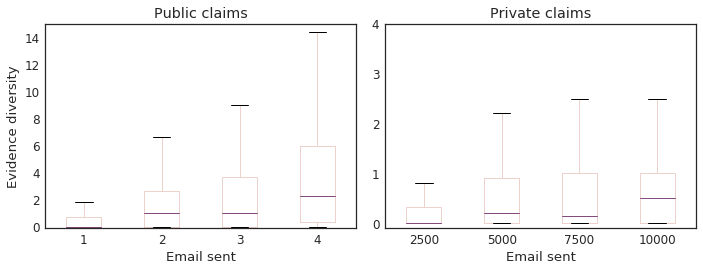

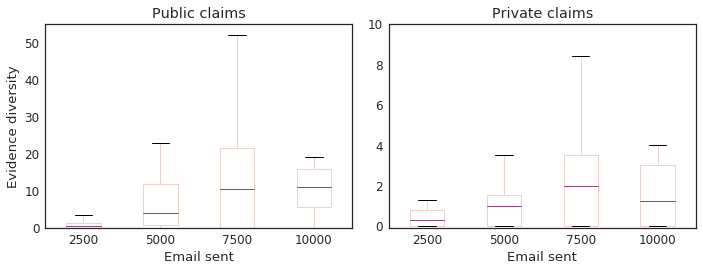

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(tight=True)
fig.set_figwidth(10)

ax = axes[0]
ax.set_xlabel("Email sent")
ax.set_ylabel("Evidence diversity")
ax.set_title('Public claims')
ax.set_ylim(-0.1, 15)

public_diversity_data_global.plot.box(ax=ax)

import matplotlib
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax = axes[1]
ax.set_xlabel("Email sent")
ax.set_title('Private claims')
ax.set_ylim(-0.1, 4)

private_diversity_data_global.plot.box(ax=ax)

fig.savefig('images/diversity_global.pdf')

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(tight=True)
fig.set_figwidth(10)

ax = axes[0]
ax.set_xlabel("Email sent")
ax.set_ylabel("Evidence diversity")
ax.set_title('Public claims')
ax.set_ylim(-0.1, 55)

public_diversity_data_userset.plot.box(ax=ax)

ax = axes[1]
ax.set_xlabel("Email sent")
ax.set_title('Private claims')
ax.set_ylim(-0.1, 10)

private_diversity_data_userset.plot.box(ax=ax)

fig.savefig('images/diversity_userset.pdf')

plt.show()

## Visualize storage

In [24]:
private_bandwidth_data, private_gossip_storage_data, private_local_storage_data = \
    get_average_storage_data(private_report, log_size=LOG_CHUNK_SIZE)
public_bandwidth_data, public_gossip_storage_data, public_local_storage_data = \
    get_average_storage_data(public_report, log_size=LOG_CHUNK_SIZE)

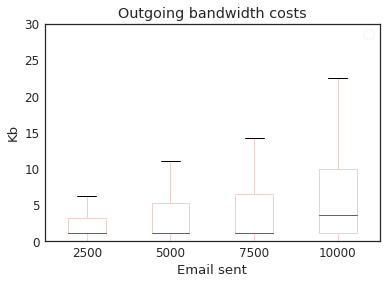

In [25]:
fig, ax = plt.subplots()

ax.legend(frameon=True, loc="right bottom")
ax.set_ylabel("Kb")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 30)
ax.set_title("Outgoing bandwidth costs")
private_bandwidth_data.plot.box(ax=ax)

fig.savefig('images/private_bandwidth.pdf')

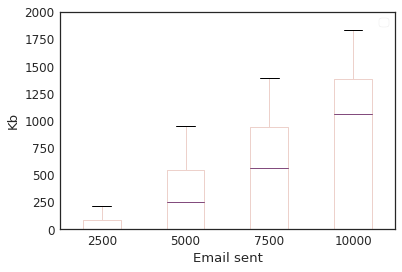

In [26]:
fig, ax = plt.subplots()

ax.legend(frameon=True, loc="right bottom")
ax.set_ylabel("Kb")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 2000)
public_bandwidth_data.plot.box(ax=ax)

fig.savefig('images/public_bandwidth.pdf')

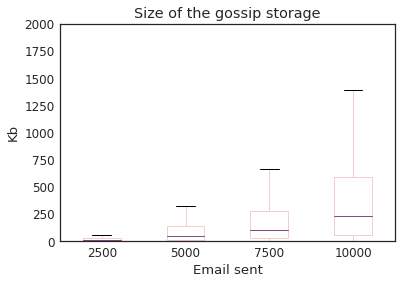

In [27]:
fig, ax = plt.subplots()

ax.set_ylabel("Kb")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 2000)
ax.set_title("Size of the gossip storage")
private_gossip_storage_data.plot.box(ax=ax)

fig.savefig('images/private_gossip_storage.pdf')

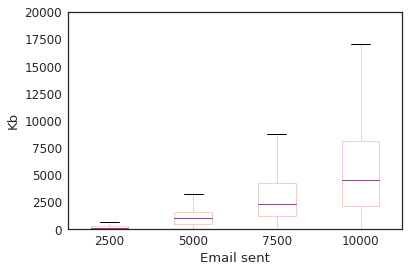

In [28]:
fig, ax = plt.subplots()

ax.set_ylabel("Kb")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 20000)
public_gossip_storage_data.plot.box(ax=ax)

fig.savefig('images/public_gossip_storage.pdf')

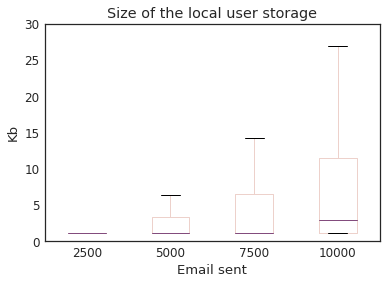

In [29]:
fig, ax = plt.subplots()

ax.set_ylabel("Kb")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 30)
ax.set_title("Size of the local user storage")
private_local_storage_data.plot.box(ax=ax)

fig.savefig('images/private_local_storage.pdf')

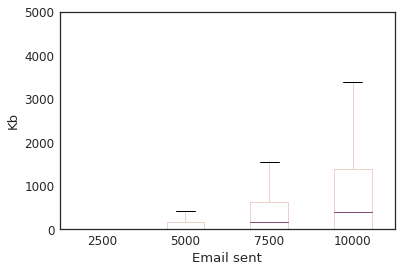

In [30]:
fig, ax = plt.subplots()

ax.set_ylabel("Kb")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 5000)
public_local_storage_data.plot.box(ax=ax)

fig.savefig('images/public_local_storage.pdf')